# Last Edited 02/11/2024 
Do not Edit

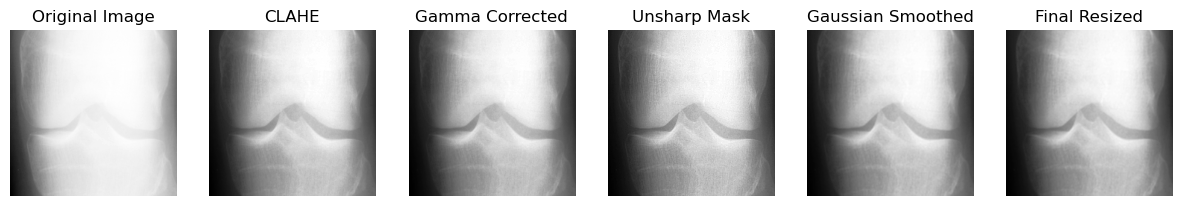

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

class ImagePreprocessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    def apply_clahe(self, clip_limit=4.0, tile_grid_size=(1, 1)):
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        clahe_img = clahe.apply(self.original_img)
        return clahe_img

    def gamma_correction(self, image, gamma=0.9):
        inv_gamma = 1.0 / gamma
        gamma_img = np.array(255 * (image / 255) ** inv_gamma, dtype='uint8')
        return gamma_img

    def unsharp_mask(self, image, strength=1.5, blur_size=(3, 3)):
        blurred = cv2.GaussianBlur(image, blur_size, 0)
        sharpened_img = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
        return sharpened_img

    def gaussian_smoothing(self, image, kernel_size=(3, 3)):
        smoothed_img = cv2.GaussianBlur(image, kernel_size, 0)
        return smoothed_img

    def normalize_image(self, image):
        normalized_img = (image - np.min(image)) / (np.max(image) - np.min(image))
        return normalized_img

    def resize_image(self, image, target_size):
        resized_img = np.array(Image.fromarray((image * 255).astype(np.uint8)).resize(target_size))
        return resized_img

    def process_and_display(self, resize=(256, 256)):
        # Perform all preprocessing steps
        clahe_img = self.apply_clahe()
        gamma_img = self.gamma_correction(clahe_img)
        sharpened_img = self.unsharp_mask(gamma_img)
        smoothed_img = self.gaussian_smoothing(sharpened_img)
        normalized_img = self.normalize_image(smoothed_img)
        final_resized_img = self.resize_image(normalized_img, resize)

        # Plot the images with headings
        images = [self.original_img, clahe_img, gamma_img, sharpened_img, smoothed_img, final_resized_img]
        titles = ['Original Image', 'CLAHE', 'Gamma Corrected', 'Unsharp Mask', 'Gaussian Smoothed', 'Final Resized']

        plt.figure(figsize=(15, 4))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, 6, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
        
        plt.show()

        return final_resized_img

# Usage
image_path = 'DATASETS/split_data/train/0/9996086L.png'
preprocessor = ImagePreprocessor(image_path)
final_image = preprocessor.process_and_display((512, 512))


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch

def process_dataset(dataset_dir):
    X = []
    y = []

    # Count total files for progress bar
    total_files = sum(len(files) for _, _, files in os.walk(dataset_dir))

    with tqdm(total=total_files, unit="images", desc="Preprocessing dataset") as pbar:
        for dirname, _, filenames in os.walk(dataset_dir):
            
            # Check if directory name is numeric, indicating a label folder
            if os.path.basename(dirname).isdigit():
                label = int(os.path.basename(dirname))  # Folder name as the label

                for filename in filenames:
                    image_path = os.path.join(dirname, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                    # Initialize preprocessor with the image path
                    preprocessor = ImagePreprocessor(image_path)
                    clahe_img = preprocessor.apply_clahe()
                    gamma_img = preprocessor.gamma_correction(clahe_img)
                    sharpened_img = preprocessor.unsharp_mask(gamma_img)
                    smoothed_img = preprocessor.gaussian_smoothing(sharpened_img)
                    normalized_img = preprocessor.normalize_image(smoothed_img)
                    final_resized_img = preprocessor.resize_image(normalized_img, (512, 512))

                    X.append(final_resized_img)
                    y.append(label)

                    pbar.update(1)
        # Convert lists to NumPy arrays first
        X_array = np.array(X)  # Convert to NumPy array
        y_array = np.array(y)
        # Convert lists to PyTorch tensors
        X_tensor = torch.tensor(X_array).float()  # Convert to float tensor
        y_tensor = torch.tensor(y_array).long()   # Convert to long tensor for labels
    return X_tensor, y_tensor


In [3]:
import torch
dataset_dir =["DATASETS/split_data/train/","DATASETS/train/train/",'DATASETS/kneeKL224/train','DATASETS/kneeKL299/train',]#"DATASETS/split_data/train/","DATASETS/train/train/"
X_train, y_train = None, None

for data in dataset_dir:
    X_temp, y_temp = process_dataset(data)
    if X_train is None:
        X_train, y_train = X_temp, y_temp
    X_train=torch.cat((X_train, X_temp), dim=0)
    y_train=torch.cat((y_train, y_temp), dim=0)

Preprocessing dataset: 100%|██████████| 5778/5778 [00:46<00:00, 124.45images/s]


In [4]:
dataset_dir = "DATASETS/split_data/val/"
X_val, y_val = process_dataset(dataset_dir)

Preprocessing dataset: 100%|██████████| 1452/1452 [00:10<00:00, 136.32images/s]


In [5]:
dataset_dir = "DATASETS/split_data/test/"
X_test, y_test = process_dataset(dataset_dir)

Preprocessing dataset: 100%|██████████| 1526/1526 [00:08<00:00, 186.19images/s]


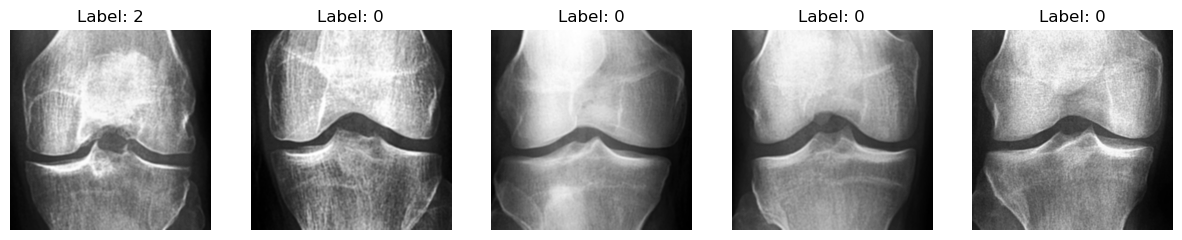

In [6]:
import matplotlib.pyplot as plt

# Plot random images with labels to check preprocessing
num_samples = 5
plt.figure(figsize=(15, 3))
for i in range(num_samples):
    idx = np.random.randint(0, len(X_train))
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.show()


In [7]:
import collections
import numpy as np

# Convert the PyTorch tensor to a NumPy array
y_train_np = y_train.numpy()

# Count the occurrences of each label
label_counts = collections.Counter(y_train_np)

# Print the label distribution
print("Label distribution:", label_counts)

Label distribution: Counter({0: 10829, 2: 8010, 1: 6254, 3: 5212, 4: 2649})


In [8]:
label_list = [label_counts[i] for i in range(len(label_counts))]

# Print the label list
print("Label counts as list:", label_list)

Label counts as list: [10829, 6254, 8010, 5212, 2649]


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchsummary import torchsummary
# import numpy as np

# class LightweightMedicalCNN(nn.Module):
#     def __init__(self, num_classes, in_channels=1):
#         super(LightweightMedicalCNN, self).__init__()
        
#         # Initial parameters
#         self.in_channels = in_channels
#         self.num_classes = num_classes
        
#         # First Convolutional Block
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         # Second Convolutional Block with Primary Caps inspiration
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         # Third Convolutional Block
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         # Spatial Attention Module
#         self.spatial_attention = nn.Sequential(
#             nn.Conv2d(128, 1, kernel_size=7, padding=3),
#             nn.Sigmoid()
#         )
        
#         # Dynamic Routing inspired module
#         self.caps_layer = nn.Sequential(
#             nn.Conv2d(128, 16, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((4, 4))
#         )
        
#         # Calculate the size for the flatten layer
#         self._to_linear = 16 * 4 * 4
        
#         # Classification layers
#         self.classifier = nn.Sequential(
#             nn.Linear(self._to_linear, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )
        
#         # Initialize weights
#         self._initialize_weights()
        
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, 0, 0.01)
#                 nn.init.constant_(m.bias, 0)
    
#     def forward(self, x):
#         # First block
#         x = self.conv1(x)
        
#         # Second block
#         x = self.conv2(x)
        
#         # Third block
#         x = self.conv3(x)
        
#         # Apply spatial attention
#         attention = self.spatial_attention(x)
#         x = x * attention
        
#         # Capsule inspired feature extraction
#         x = self.caps_layer(x)
        
#         # Flatten
#         x = x.view(x.size(0), -1)
        
#         # Classification
#         x = self.classifier(x)
        
#         return x

# def print_model_summary(model, input_size=(1, 512, 512)):
#     """
#     Print model summary and calculate model size
#     """
#     # Convert input size to include batch dimension
#     batch_size = 1
#     input_shape = (batch_size, *input_size)
    
#     # Create dummy input
#     dummy_input = torch.randn(input_shape)
    
#     # Print model architecture
#     print("\nModel Architecture:")
#     print(model)
    
#     # Calculate total parameters
#     total_params = sum(p.numel() for p in model.parameters())
#     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
#     print(f"\nTotal Parameters: {total_params:,}")
#     print(f"Trainable Parameters: {trainable_params:,}")
    
#     # Estimate model size in MB
#     model_size_mb = total_params * 4 / (1024 * 1024)  # Assuming 4 bytes per parameter
#     print(f"Estimated Model Size: {model_size_mb:.2f} MB")
    
#     # Test forward pass
#     try:
#         output = model(dummy_input)
#         print(f"\nInput Shape: {input_shape}")
#         print(f"Output Shape: {output.shape}")
#         print("\nModel summary test passed successfully!")
#     except Exception as e:
#         print(f"\nError during forward pass: {str(e)}")

# # Example usage
# def test_model(num_classes=5):
#     """
#     Test the model with sample data
#     """
#     # Initialize model
#     model = LightweightMedicalCNN(num_classes=num_classes, in_channels=1)
    
#     # Print model summary
#     print_model_summary(model)
    
#     return model

In [11]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from typing import Tuple, List

# class EfficientMedicalNet(nn.Module):
#     def __init__(self, num_classes: int, in_channels: int = 1):
#         super().__init__()
        
#         # Hyperparameters for the network
#         self.initial_channels = 32
#         self.reduction_ratio = 4  # For SE blocks
        
#         # Initial convolution with instance norm for better generalization
#         self.initial_conv = nn.Sequential(
#             nn.Conv2d(in_channels, self.initial_channels, kernel_size=7, stride=2, padding=3),
#             nn.InstanceNorm2d(self.initial_channels, affine=True),  # Added affine=True
#             nn.GELU()
#         )
        
#         # Create the main network structure
#         self.stage1 = self._make_stage(self.initial_channels, 64, stride=2)
#         self.stage2 = self._make_stage(64, 128, stride=2)
#         self.stage3 = self._make_stage(128, 256, stride=2)
#         self.stage4 = self._make_stage(256, 512, stride=2)
        
#         # Global feature refinement
#         self.global_pool = nn.AdaptiveAvgPool2d(1)
#         self.dropout = nn.Dropout(0.2)
        
#         # Multi-scale feature fusion
#         self.fusion_conv = nn.Sequential(
#             nn.Conv2d(960, 512, kernel_size=1),  # 960 = 128 + 256 + 512 + 64
#             nn.InstanceNorm2d(512, affine=True),  # Added affine=True
#             nn.GELU()
#         )
        
#         # Classifier
#         self.classifier = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.GELU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_classes)
#         )
        
#         self._initialize_weights()

#     def _make_stage(self, in_channels: int, out_channels: int, stride: int) -> nn.Sequential:
#         """Creates a stage with depthwise separable convolutions and SE attention"""
#         return nn.Sequential(
#             DepthwiseSeparableConv(in_channels, out_channels, stride),
#             SEBlock(out_channels),
#             ResidualBlock(out_channels)
#         )
    
#     def _initialize_weights(self):
#         """Initialize network weights using He initialization"""
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight)
#                 nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.InstanceNorm2d) and m.affine:
#                 if m.weight is not None:
#                     nn.init.ones_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         # Initial processing
#         x = self.initial_conv(x)
        
#         # Multi-scale feature extraction
#         f1 = self.stage1(x)
#         f2 = self.stage2(f1)
#         f3 = self.stage3(f2)
#         f4 = self.stage4(f3)
        
#         # Multi-scale feature fusion
#         # Upsample all features to f2's size for fusion
#         f3_up = F.interpolate(f3, size=f2.shape[2:])
#         f4_up = F.interpolate(f4, size=f2.shape[2:])
#         f1_down = F.interpolate(f1, size=f2.shape[2:])
        
#         # Concatenate features and apply fusion
#         fused = torch.cat([f1_down, f2, f3_up, f4_up], dim=1)
#         fused = self.fusion_conv(fused)
        
#         # Global pooling and classification
#         out = self.global_pool(fused)
#         out = out.view(out.size(0), -1)
#         out = self.dropout(out)
#         out = self.classifier(out)
        
#         return out

# class DepthwiseSeparableConv(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
#         super().__init__()
        
#         self.conv = nn.Sequential(
#             # Depthwise convolution
#             nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, 
#                      padding=1, groups=in_channels, bias=False),
#             nn.InstanceNorm2d(in_channels, affine=True),
#             nn.GELU(),
#             # Pointwise convolution
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
#             nn.InstanceNorm2d(out_channels, affine=True),
#             nn.GELU()
#         )
        
#         # Skip connection if dimensions change
#         self.skip = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#             nn.InstanceNorm2d(out_channels, affine=True)
#         ) if stride != 1 or in_channels != out_channels else nn.Identity()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.conv(x) + self.skip(x)

# class SEBlock(nn.Module):
#     """Squeeze-and-Excitation block for channel attention"""
#     def __init__(self, channels: int, reduction: int = 4):
#         super().__init__()
        
#         self.squeeze = nn.AdaptiveAvgPool2d(1)
#         self.excitation = nn.Sequential(
#             nn.Linear(channels, channels // reduction),
#             nn.GELU(),
#             nn.Linear(channels // reduction, channels),
#             nn.Sigmoid()
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         b, c, _, _ = x.size()
#         y = self.squeeze(x).view(b, c)
#         y = self.excitation(y).view(b, c, 1, 1)
#         return x * y

# class ResidualBlock(nn.Module):
#     """Residual block with pre-activation"""
#     def __init__(self, channels: int):
#         super().__init__()
        
#         self.conv = nn.Sequential(
#             nn.InstanceNorm2d(channels, affine=True),
#             nn.GELU(),
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
#             nn.InstanceNorm2d(channels, affine=True),
#             nn.GELU(),
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return x + self.conv(x)

# def print_model_summary(model: nn.Module, input_size: Tuple[int, int, int] = (1, 512, 512)):
#     """Print model summary and test forward pass"""
#     batch_size = 1
#     input_shape = (batch_size, *input_size)
#     dummy_input = torch.randn(input_shape)
    
#     # Calculate model statistics
#     total_params = sum(p.numel() for p in model.parameters())
#     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     model_size_mb = total_params * 4 / (1024 * 1024)
    
#     print(f"\nModel Statistics:")
#     print(f"Total Parameters: {total_params:,}")
#     print(f"Trainable Parameters: {trainable_params:,}")
#     print(f"Estimated Model Size: {model_size_mb:.2f} MB")
    
#     try:
#         model.eval()
#         with torch.no_grad():
#             output = model(dummy_input)
#         print(f"Input Shape: {dummy_input.shape}")
#         print(f"Output Shape: {output.shape}")
#         print("\nModel architecture test passed successfully!")
#     except Exception as e:
#         print(f"\nError during forward pass: {str(e)}")

# # if __name__ == "__main__":
# #     model = EfficientMedicalNet(num_classes=5, in_channels=1)
# #     print_model_summary(model)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, List

class LightEfficientMedicalNet(nn.Module):
    def __init__(self, num_classes: int, in_channels: int = 1):
        super().__init__()
        
        # Reduced initial channels
        self.initial_channels = 16  # Reduced from 32
        self.reduction_ratio = 8    # Increased from 4 for fewer SE parameters
        
        # Initial convolution with reduced channels
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels, self.initial_channels, kernel_size=5, stride=2, padding=2),  # Reduced kernel size
            nn.InstanceNorm2d(self.initial_channels, affine=True),
            nn.GELU()
        )
        
        # Reduced channel progression
        self.stage1 = self._make_stage(self.initial_channels, 32, stride=2)   # Reduced from 64
        self.stage2 = self._make_stage(32, 64, stride=2)                      # Reduced from 128
        self.stage3 = self._make_stage(64, 128, stride=2)                     # Reduced from 256
        self.stage4 = self._make_stage(128, 256, stride=2)                    # Reduced from 512
        
        # Global feature refinement
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        
        # Multi-scale feature fusion with reduced channels
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(480, 256, kernel_size=1),  # 480 = 32 + 64 + 128 + 256
            nn.InstanceNorm2d(256, affine=True),
            nn.GELU()
        )
        
        # Classifier with reduced dimensions
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),    # Reduced from 512, 256
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
        self._initialize_weights()

    def _make_stage(self, in_channels: int, out_channels: int, stride: int) -> nn.Sequential:
        """Creates a lightweight stage"""
        return nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, stride),
            SEBlock(out_channels, self.reduction_ratio),
            LightResidualBlock(out_channels)  # Using lightweight residual block
        )
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.InstanceNorm2d) and m.affine:
                if m.weight is not None:
                    nn.init.ones_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.initial_conv(x)
        
        f1 = self.stage1(x)
        f2 = self.stage2(f1)
        f3 = self.stage3(f2)
        f4 = self.stage4(f3)
        
        f3_up = F.interpolate(f3, size=f2.shape[2:])
        f4_up = F.interpolate(f4, size=f2.shape[2:])
        f1_down = F.interpolate(f1, size=f2.shape[2:])
        
        fused = torch.cat([f1_down, f2, f3_up, f4_up], dim=1)
        fused = self.fusion_conv(fused)
        
        out = self.global_pool(fused)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.classifier(out)
        
        return out

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        
        self.conv = nn.Sequential(
            # Depthwise convolution
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, 
                     padding=1, groups=in_channels, bias=False),
            nn.InstanceNorm2d(in_channels, affine=True),
            nn.GELU(),
            # Pointwise convolution
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.GELU()
        )
        
        self.skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True)
        ) if stride != 1 or in_channels != out_channels else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x) + self.skip(x)

class SEBlock(nn.Module):
    """Lightweight Squeeze-and-Excitation block"""
    def __init__(self, channels: int, reduction: int = 8):
        super().__init__()
        
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.GELU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y

class LightResidualBlock(nn.Module):
    """Lightweight residual block with reduced parameters"""
    def __init__(self, channels: int):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.InstanceNorm2d(channels, affine=True),
            nn.GELU(),
            # Using a single 3x3 conv instead of two
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.conv(x)

def print_model_summary(model: nn.Module, input_size: Tuple[int, int, int] = (1, 512, 512)):
    batch_size = 1
    input_shape = (batch_size, *input_size)
    dummy_input = torch.randn(input_shape)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = total_params * 4 / (1024 * 1024)
    
    print(f"\nModel Statistics:")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Estimated Model Size: {model_size_mb:.2f} MB")
    
    try:
        model.eval()
        with torch.no_grad():
            output = model(dummy_input)
        print(f"Input Shape: {dummy_input.shape}")
        print(f"Output Shape: {output.shape}")
        print("\nModel architecture test passed successfully!")
    except Exception as e:
        print(f"\nError during forward pass: {str(e)}")

# # Example usage
# if __name__ == "__main__":
#     model = LightEfficientMedicalNet(num_classes=5, in_channels=1)
#     print_model_summary(model)

## Augmentation

### Do actual Augmentation

# THIS IS REMOVED

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import wandb
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from typing import Dict, Tuple
import os
from datetime import datetime

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, transform=None):
        self.X = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.X[idx]), self.y[idx]
        return self.X[idx], self.y[idx]

In [15]:

def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    device: str = None,
    save_path: str = None
):
    """Evaluate model on test set and generate detailed metrics"""
    device = device or torch.device("cuda")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Generate classification report
    report = classification_report(all_targets, all_preds, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    if save_path:
        # Save results
        plt.savefig(os.path.join(save_path, 'confusion_matrix.png'))
        report_df.to_csv(os.path.join(save_path, 'classification_report.csv'))
    
    plt.show()
    print("\nClassification Report:")
    print(report_df)
    
    return report_df, cm

In [16]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, current_val):
        if self.best_loss is None:
            self.best_loss = current_val
        elif current_val > self.best_loss + self.min_delta and self.mode == 'min':
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = current_val
            self.counter = 0

class Trainer:
    def __init__(
        self,
        model: nn.Module,
        config: Dict,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: nn.Module = None,
        optimizer: optim.Optimizer = None,
        scheduler = None,
        device: str = None
    ):
        self.config = config
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optimizer or optim.AdamW(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        self.scheduler = scheduler or optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=3, factor=0.1
        )
        self.device = device or torch.device("cuda")
        self.model = self.model.to(self.device)
        self.scaler = GradScaler('cuda')
        self.early_stopping = EarlyStopping(patience=config['early_stopping_patience'])
        
        # Initialize metrics tracking
        self.best_val_loss = float('inf')
        self.best_val_acc = 0.0
        
        # Setup WandB
        self.run = wandb.init(
            project=config['project_name'],
            config=config,
            name=f"{config['model_name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        )
        
        # Save paths
        self.save_dir = config['save_dir']
        os.makedirs(self.save_dir, exist_ok=True)
        
    def train_epoch(self) -> Tuple[float, float]:
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Mixed precision training
            with autocast('cuda'):
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
            
            # Backward pass with gradient scaling
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            # Metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })
            
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def validate_epoch(self) -> Tuple[float, float]:
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation')
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                
                pbar.set_postfix({
                    'loss': running_loss/(batch_idx+1),
                    'acc': 100.*correct/total
                })
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        
        # Log confusion matrix to WandB
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Validation Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()
        
        return epoch_loss, epoch_acc
    
    def train(self, epochs: int):
        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')
            
            # Training phase
            train_loss, train_acc = self.train_epoch()
            
            # Validation phase
            val_loss, val_acc = self.validate_epoch()
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Logging
            wandb.log({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": current_lr
            })
            
            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.save_model('best_model.pth')
            
            # Early stopping check
            self.early_stopping(val_loss)
            if self.early_stopping.early_stop:
                print("Early stopping triggered")
                break
        
        # Save final model
        self.save_model('final_model.pth')
        self.run.finish()
    
    def save_model(self, filename: str):
        """Save model with config and metrics"""
        save_path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'config': self.config,
            'best_val_acc': self.best_val_acc,
            'best_val_loss': self.best_val_loss
        }, save_path)
        wandb.save(save_path)

# Example usage
def main():
    # Configuration
    config = {
        'project_name': 'image_classification',
        'model_name': 'EnhancedXRayClassifier',
        'learning_rate': 0.0001,
        'weight_decay': 1e-4,
        'batch_size': 20,
        'early_stopping_patience': 8,
        'save_dir': './models',
        'num_epochs': 100
    }
    
    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
    )
    
    # Initialize model and trainer
    model = LightEfficientMedicalNet(num_classes=5)  # Your model class
    class_weights = [1 / count for count in label_list]
    class_weights = torch.FloatTensor(class_weights)
    device = torch.device("cuda")
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    trainer = Trainer(
        model=model,
        config=config,
        criterion=criterion,
        train_loader=train_loader,
        val_loader=val_loader
    )

    # Train model
    trainer.train(epochs=config['num_epochs'])

if __name__ == "__main__":
    main()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ramachandraudupa-sangamone (ramachandraudupa-sangamone-smvitm). Use `wandb login --relogin` to force relogin



Epoch 1/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 2/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 3/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 4/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 5/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 6/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 7/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 8/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 9/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 10/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 11/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 12/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 13/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 14/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 15/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 16/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 17/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 18/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 19/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 20/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 21/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 22/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 23/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 24/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 25/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 26/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 27/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 28/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 29/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 30/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 31/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 32/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 33/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]


Epoch 34/100


Training:   0%|          | 0/1648 [00:00<?, ?it/s]

Validation:   0%|          | 0/73 [00:00<?, ?it/s]

Early stopping triggered


/tmp/ipykernel_5588/1942159943.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./models/best_model.pth')


Testing:   0%|          | 0/48 [00:00<?, ?it/s]

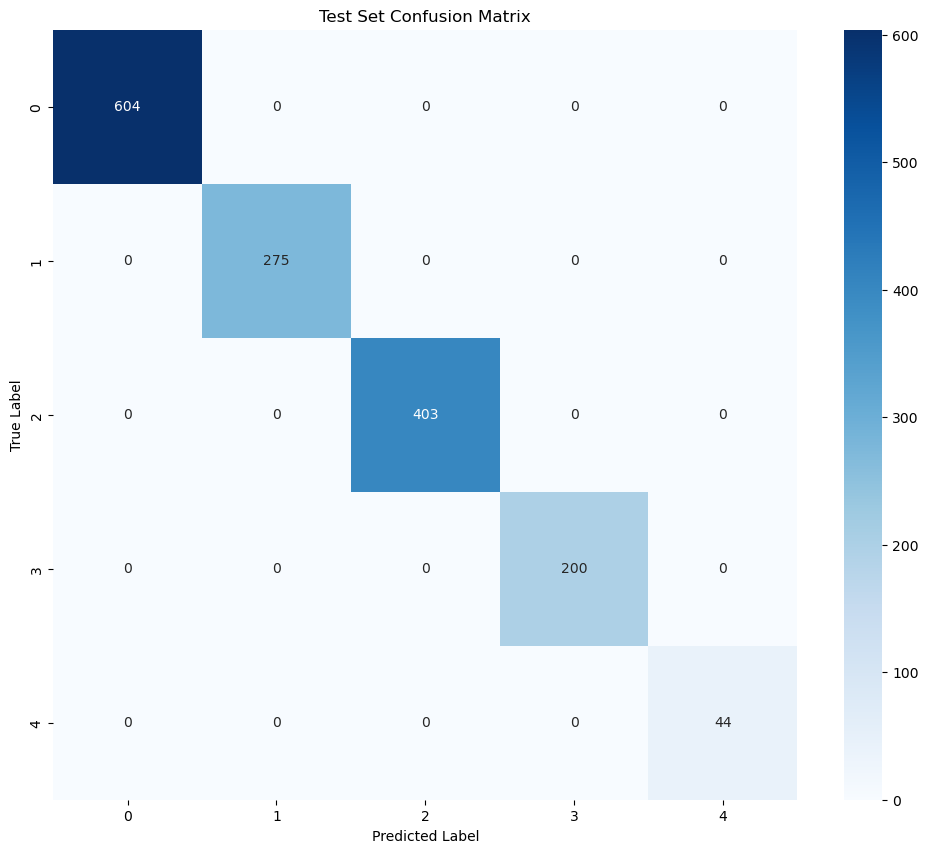


Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0    604.0
1                   1.0     1.0       1.0    275.0
2                   1.0     1.0       1.0    403.0
3                   1.0     1.0       1.0    200.0
4                   1.0     1.0       1.0     44.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1526.0
weighted avg        1.0     1.0       1.0   1526.0


In [17]:
# Create test dataset and loader
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1
)
model = LightEfficientMedicalNet(num_classes=5)
# Load best model
checkpoint = torch.load('./models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device("cpu")
model = model.to(device)

# Evaluate
report_df, confusion_matrix = evaluate_model(
    model,
    test_loader,
    save_path='./results'
)

/tmp/ipykernel_5588/1095042003.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


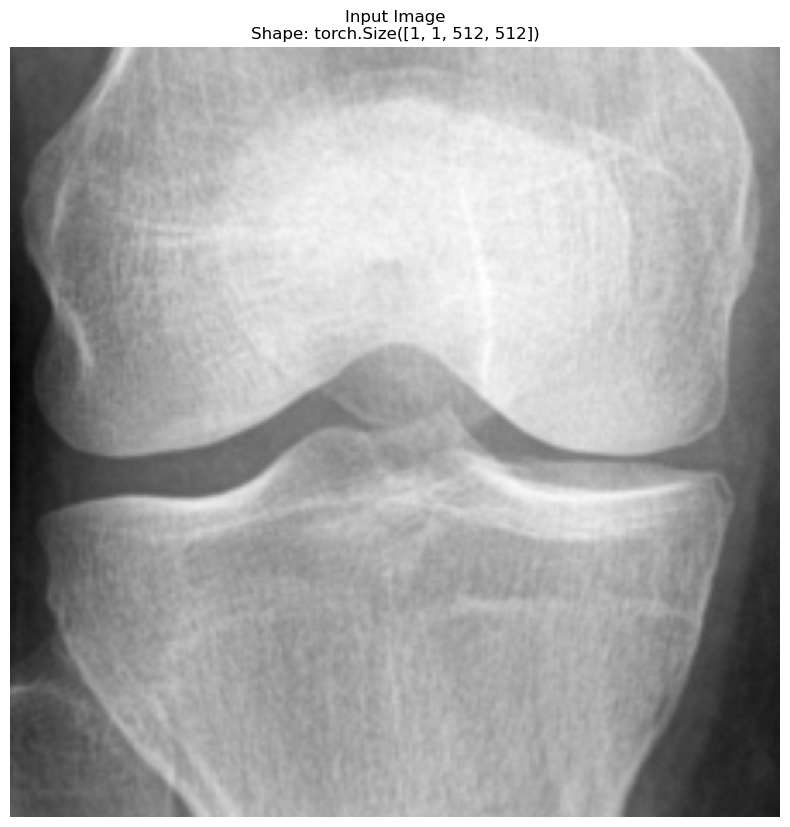

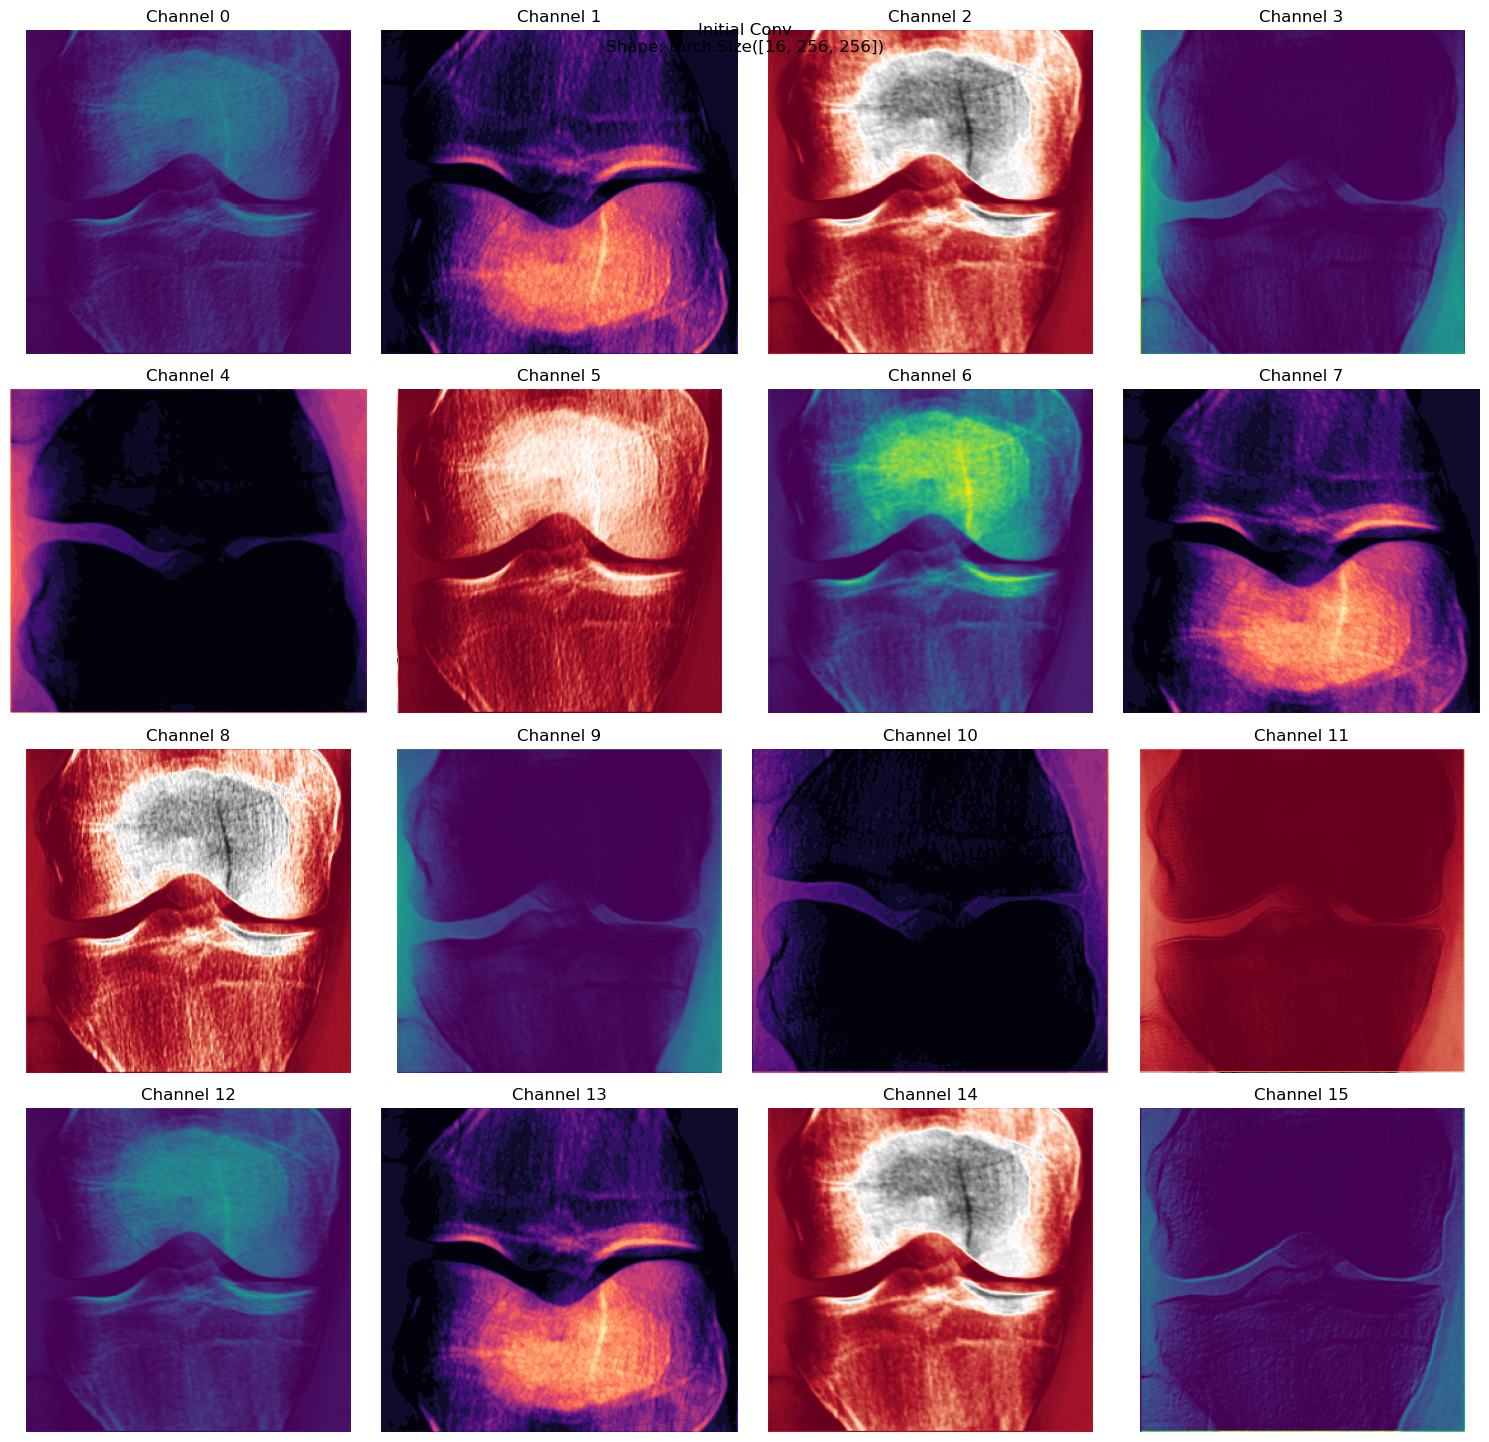

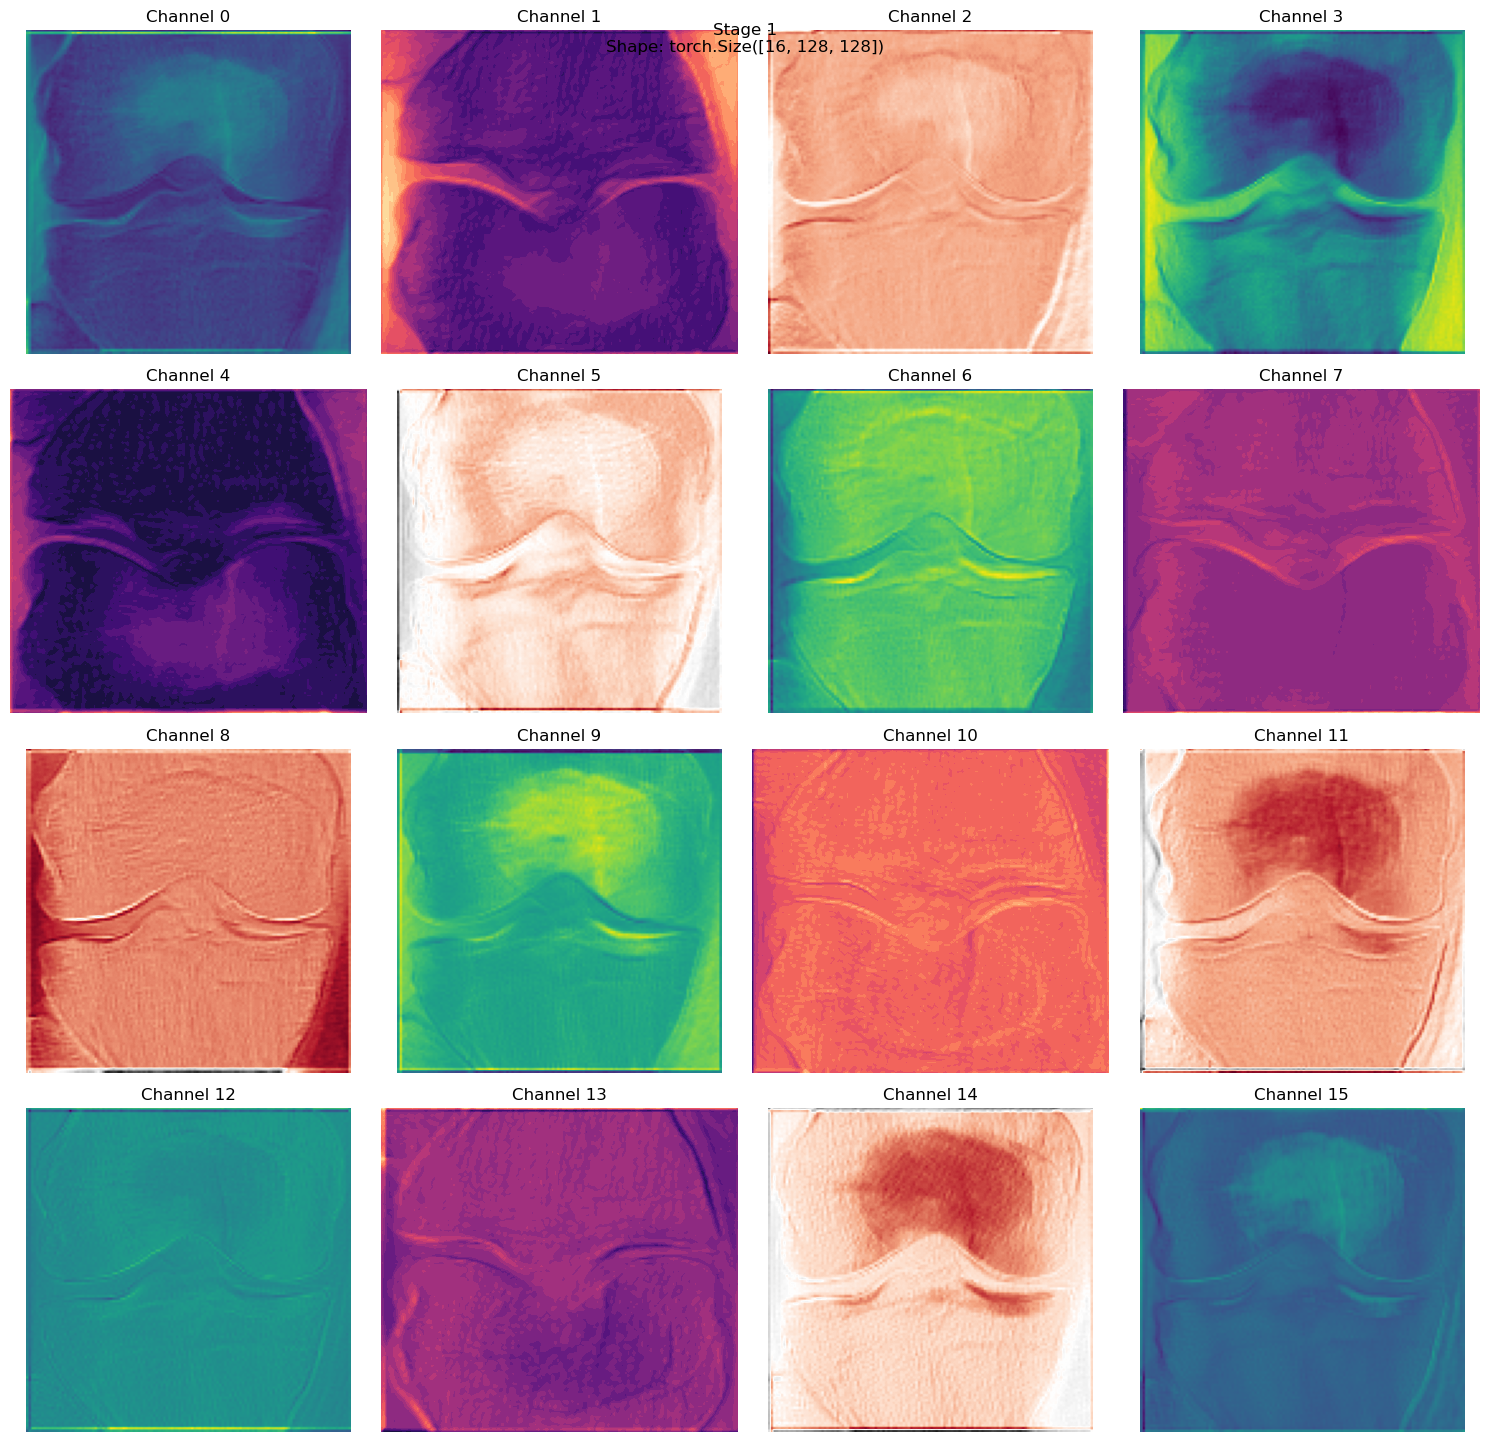

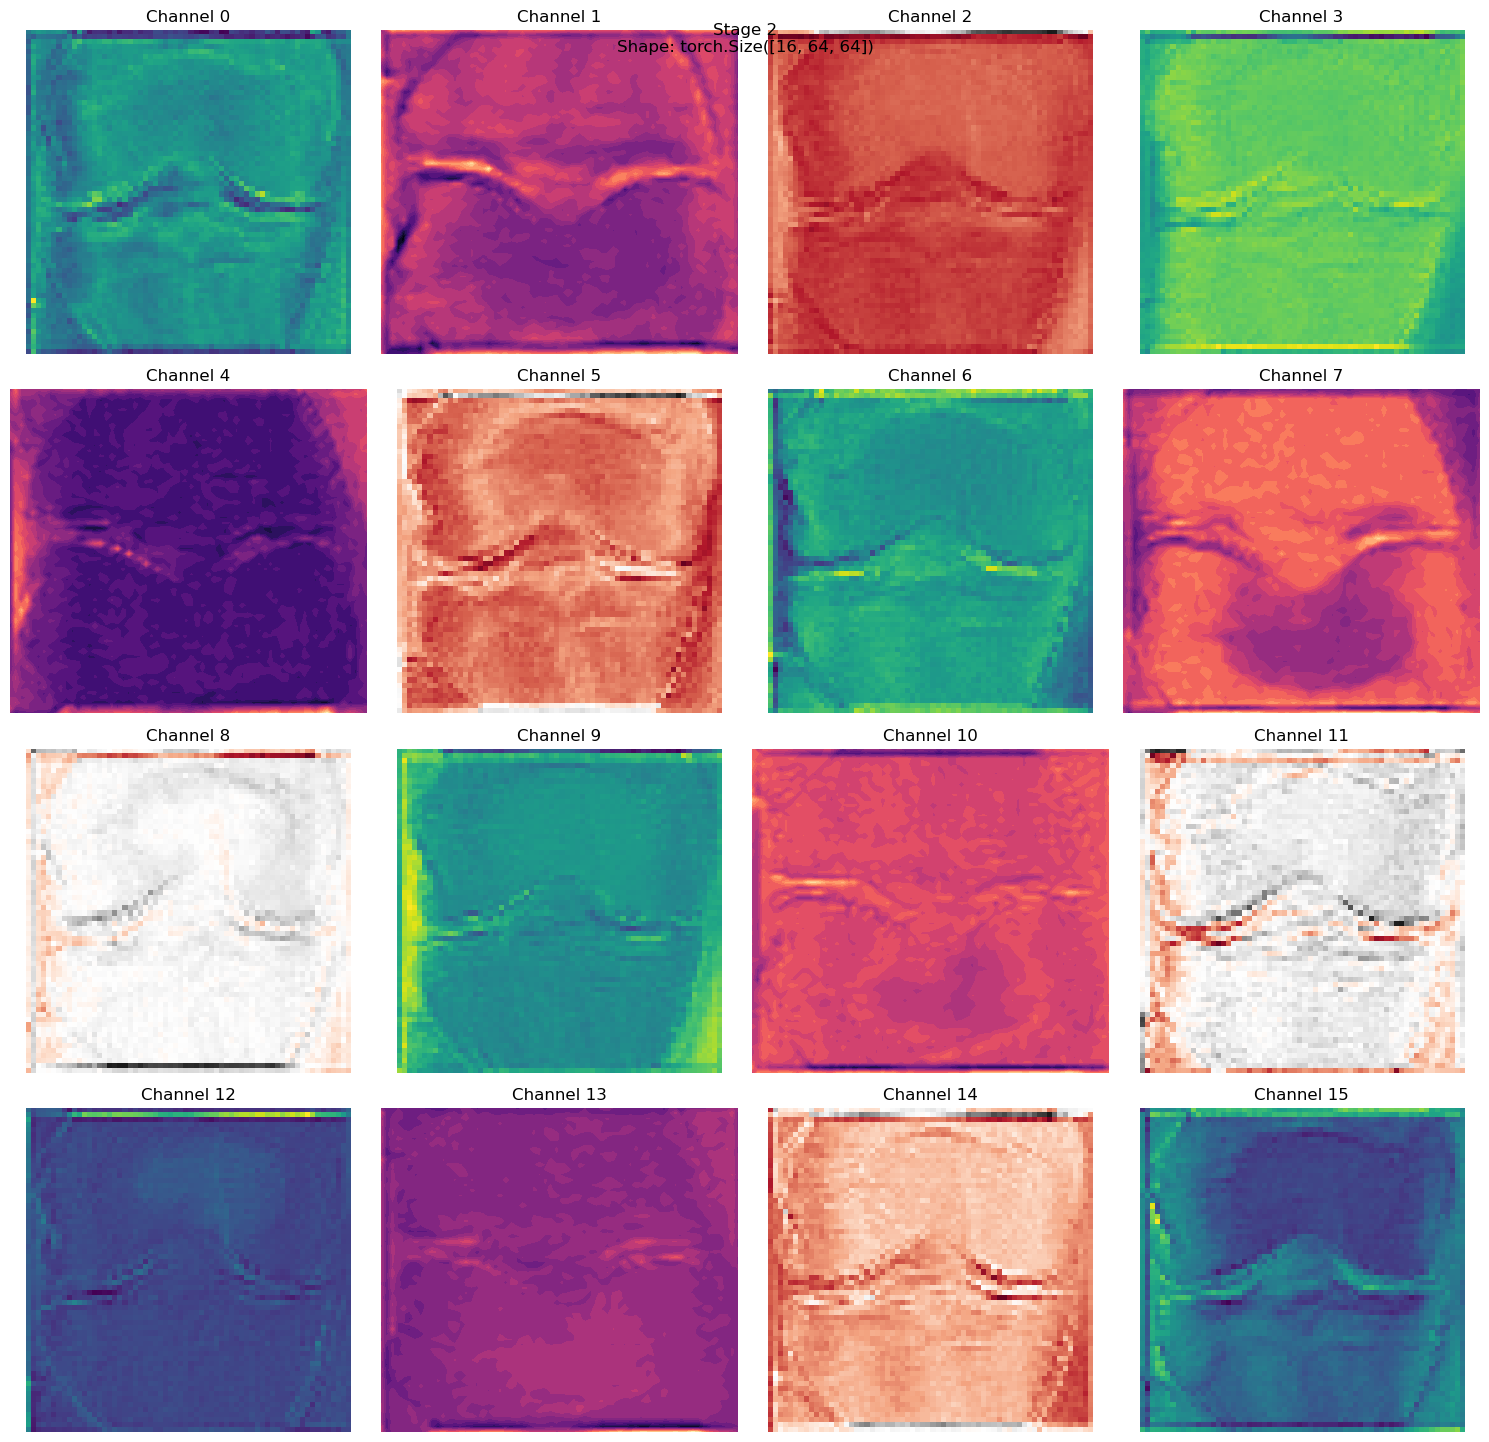

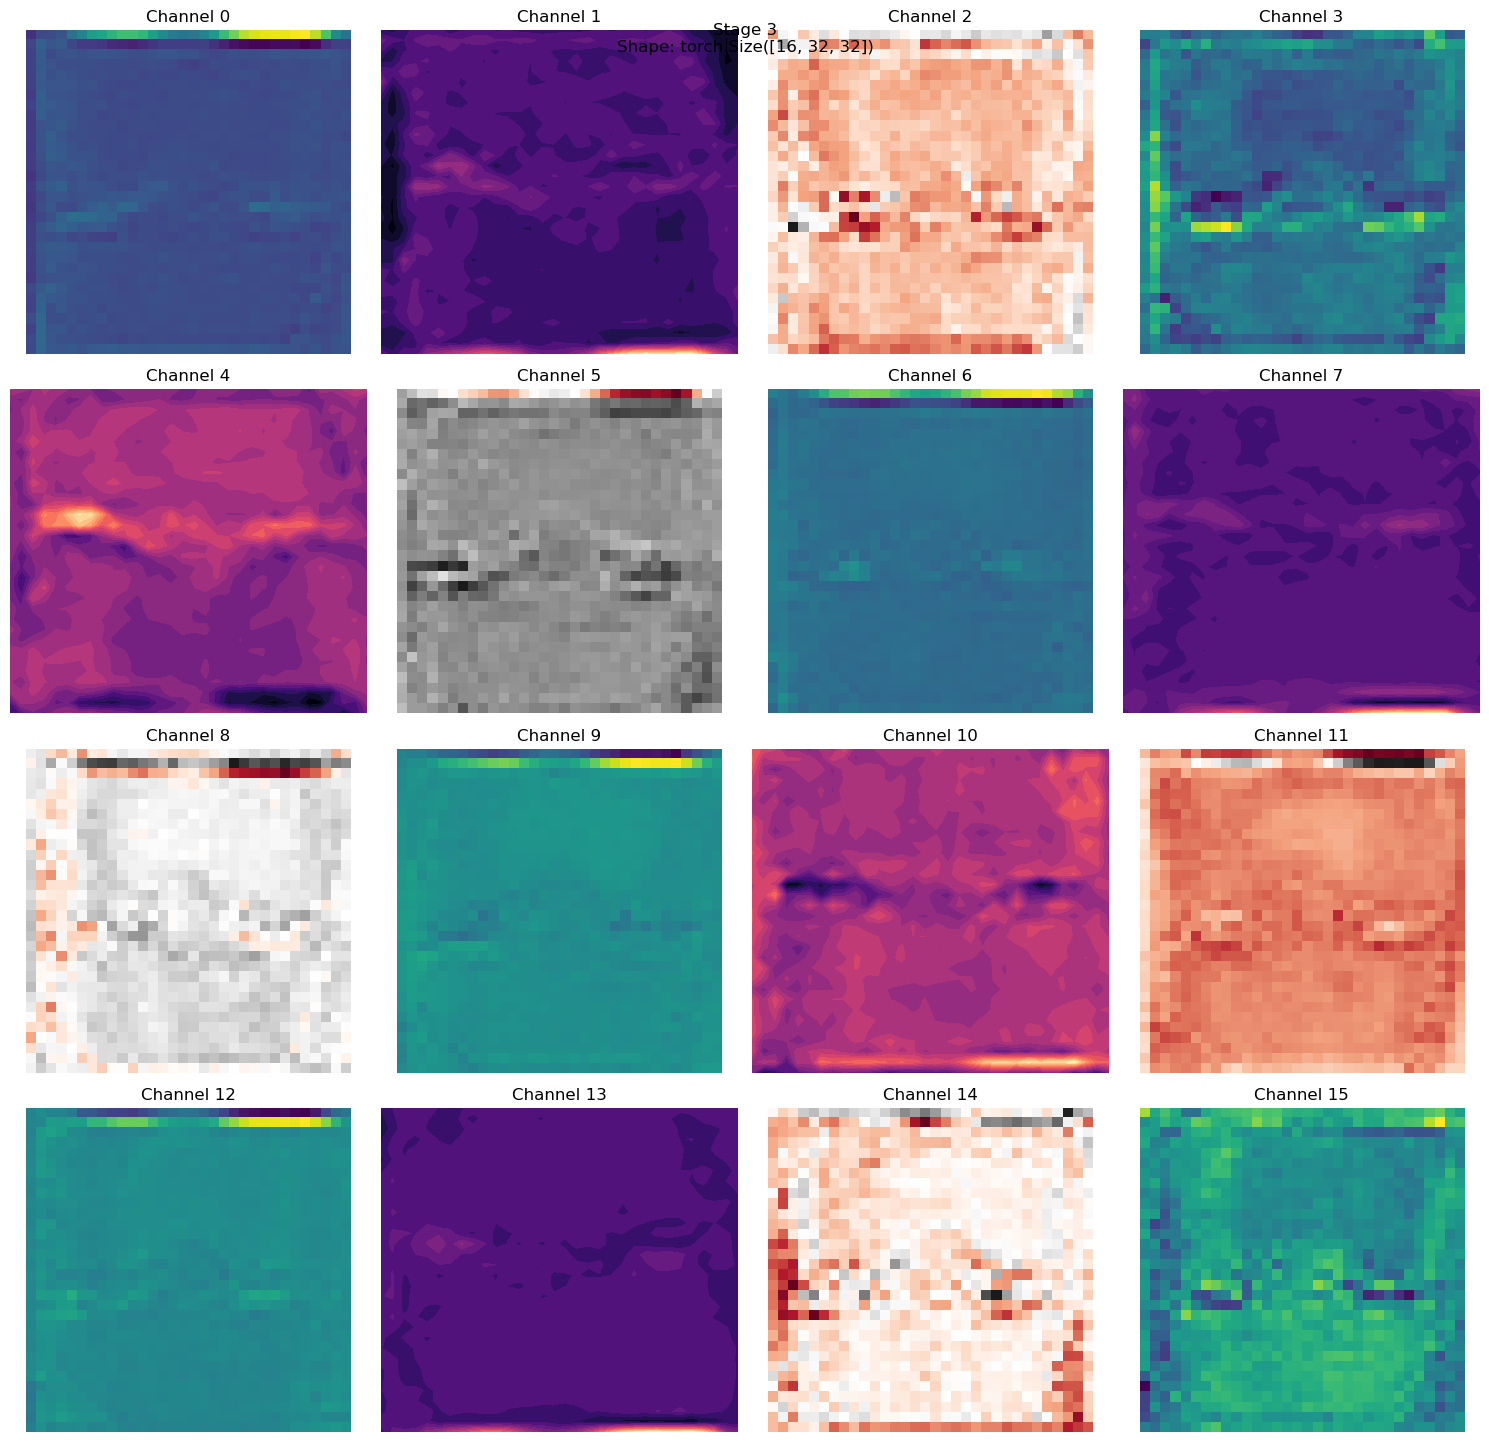

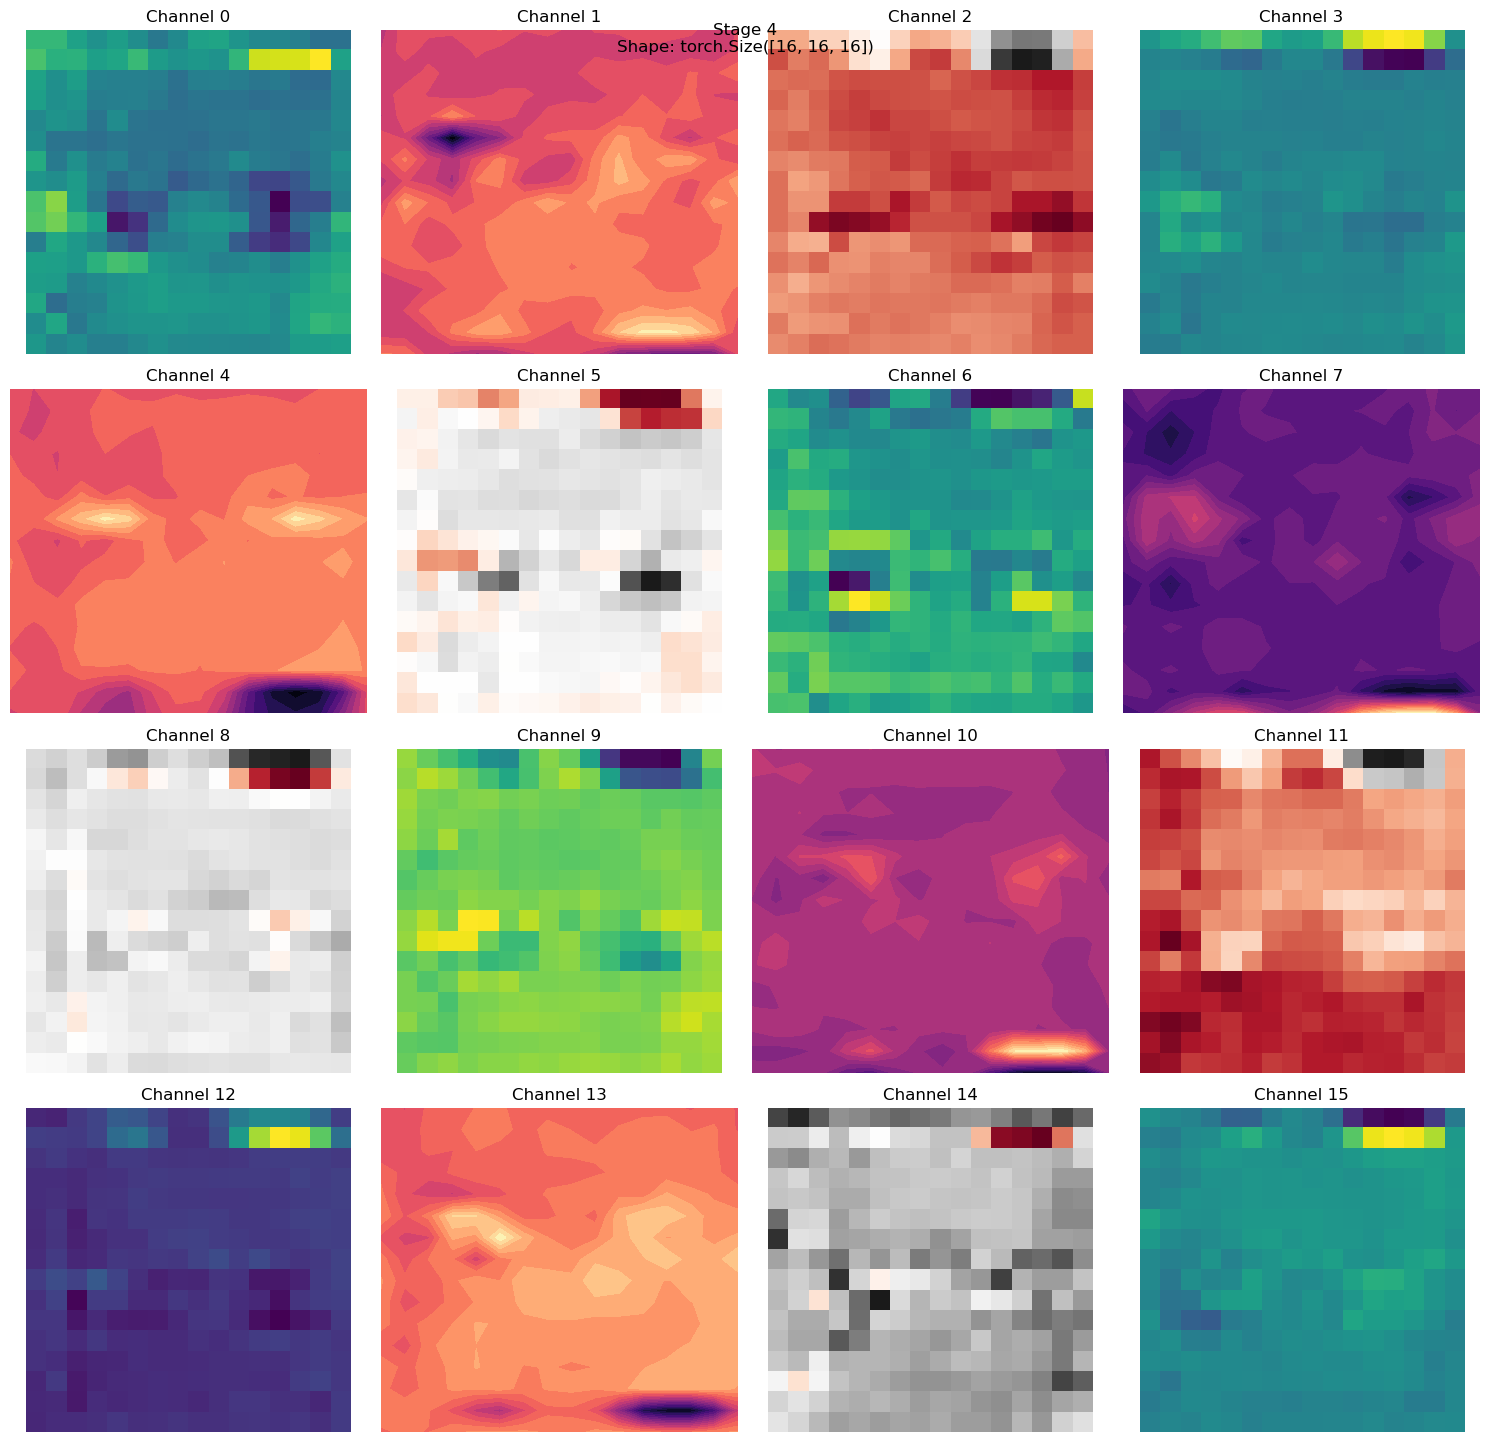

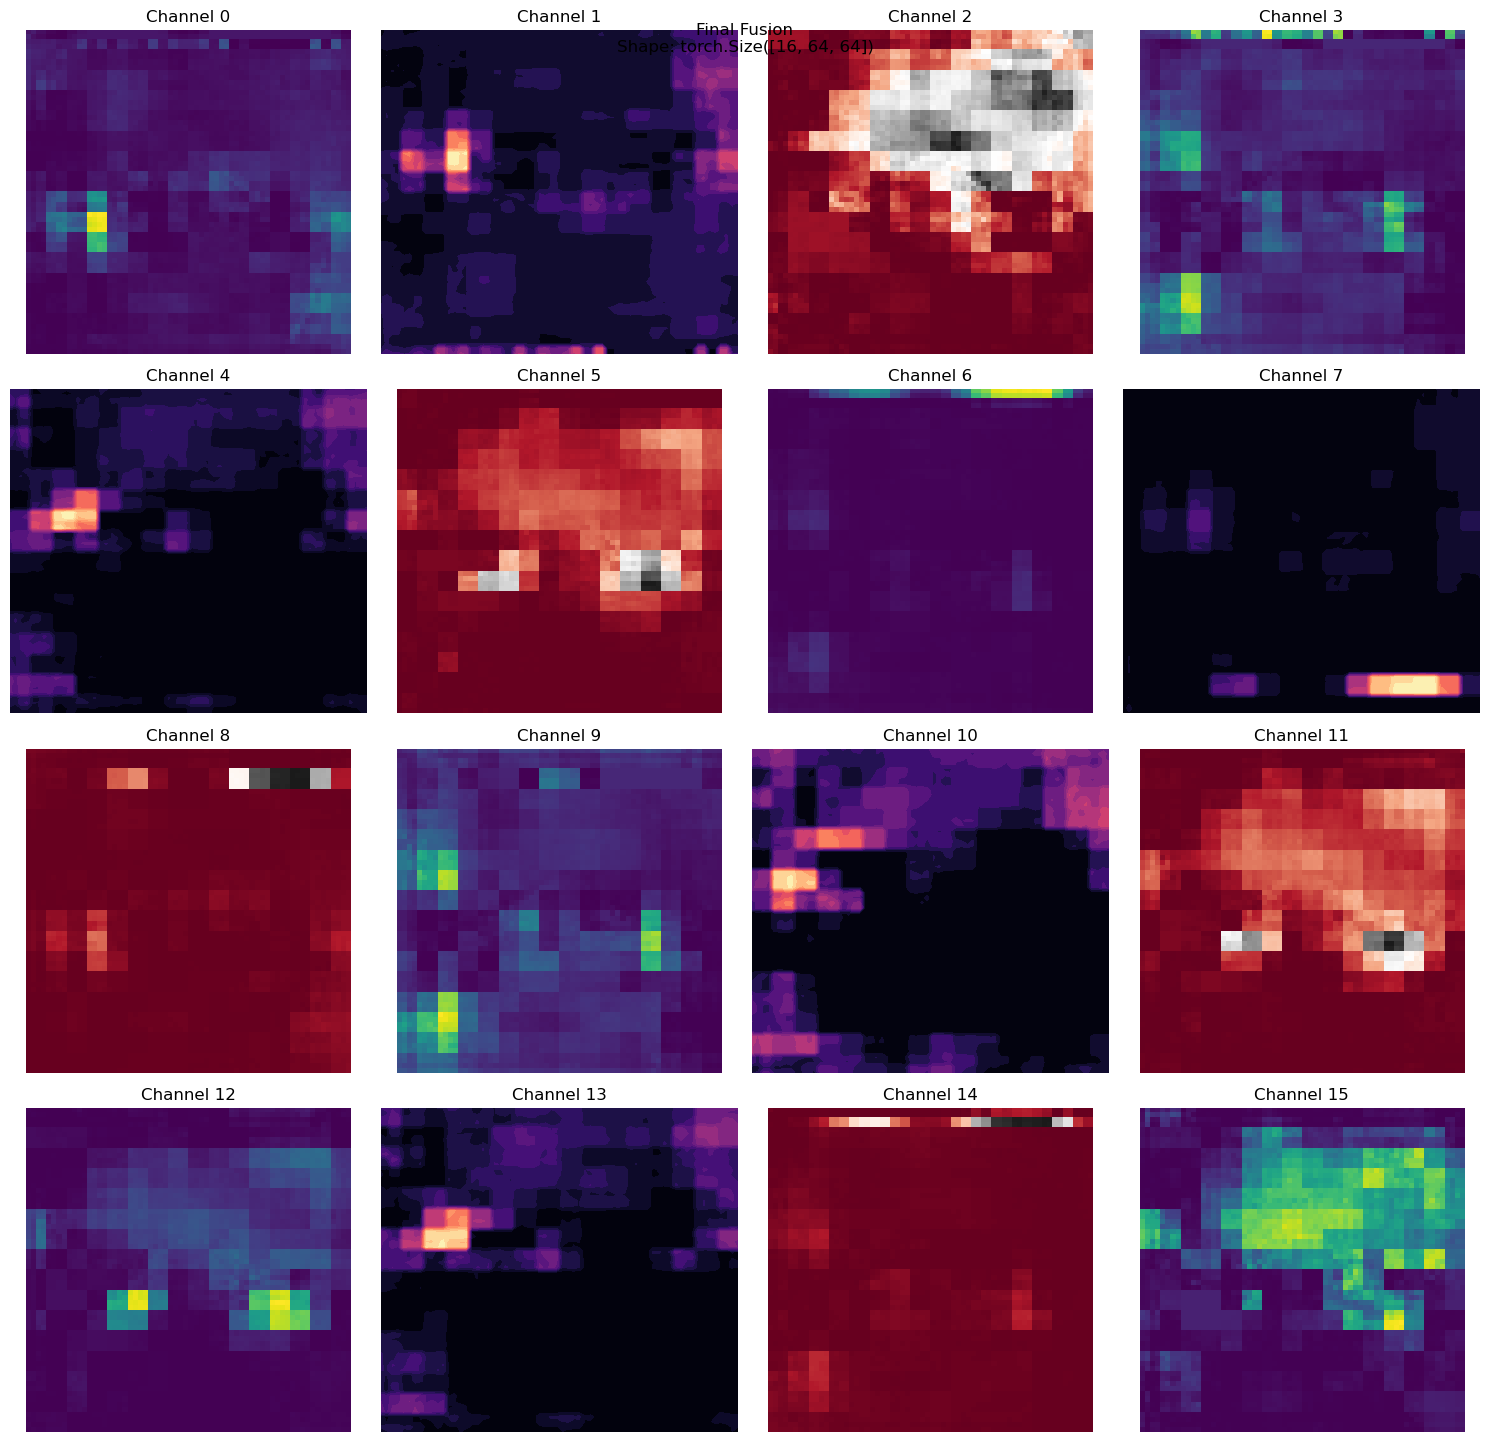

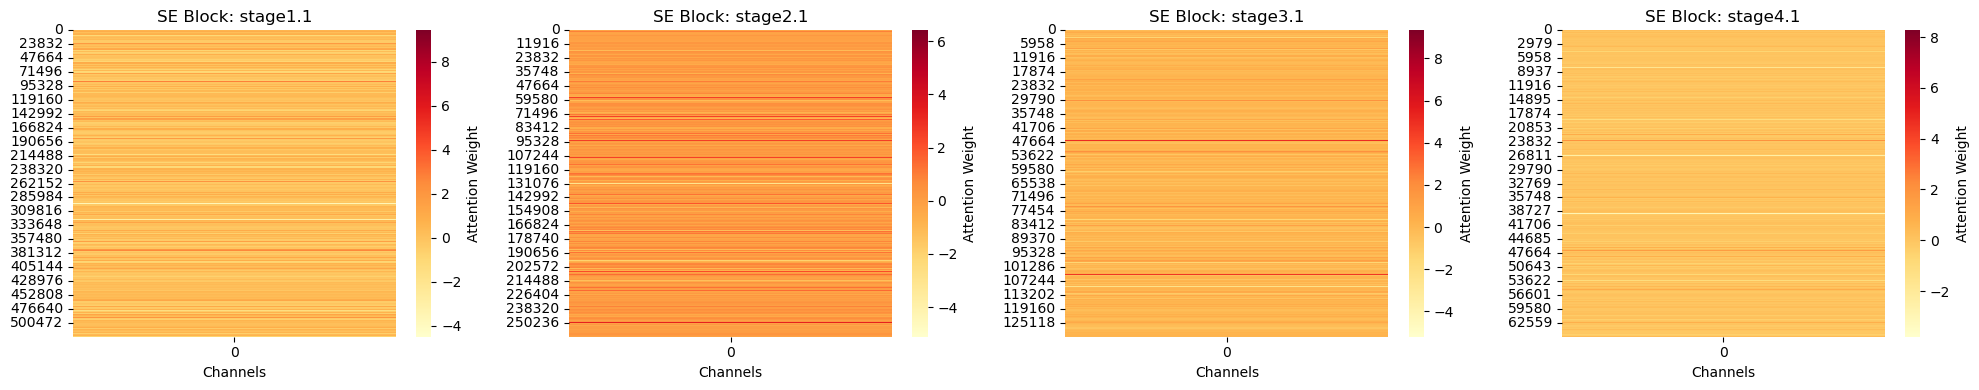

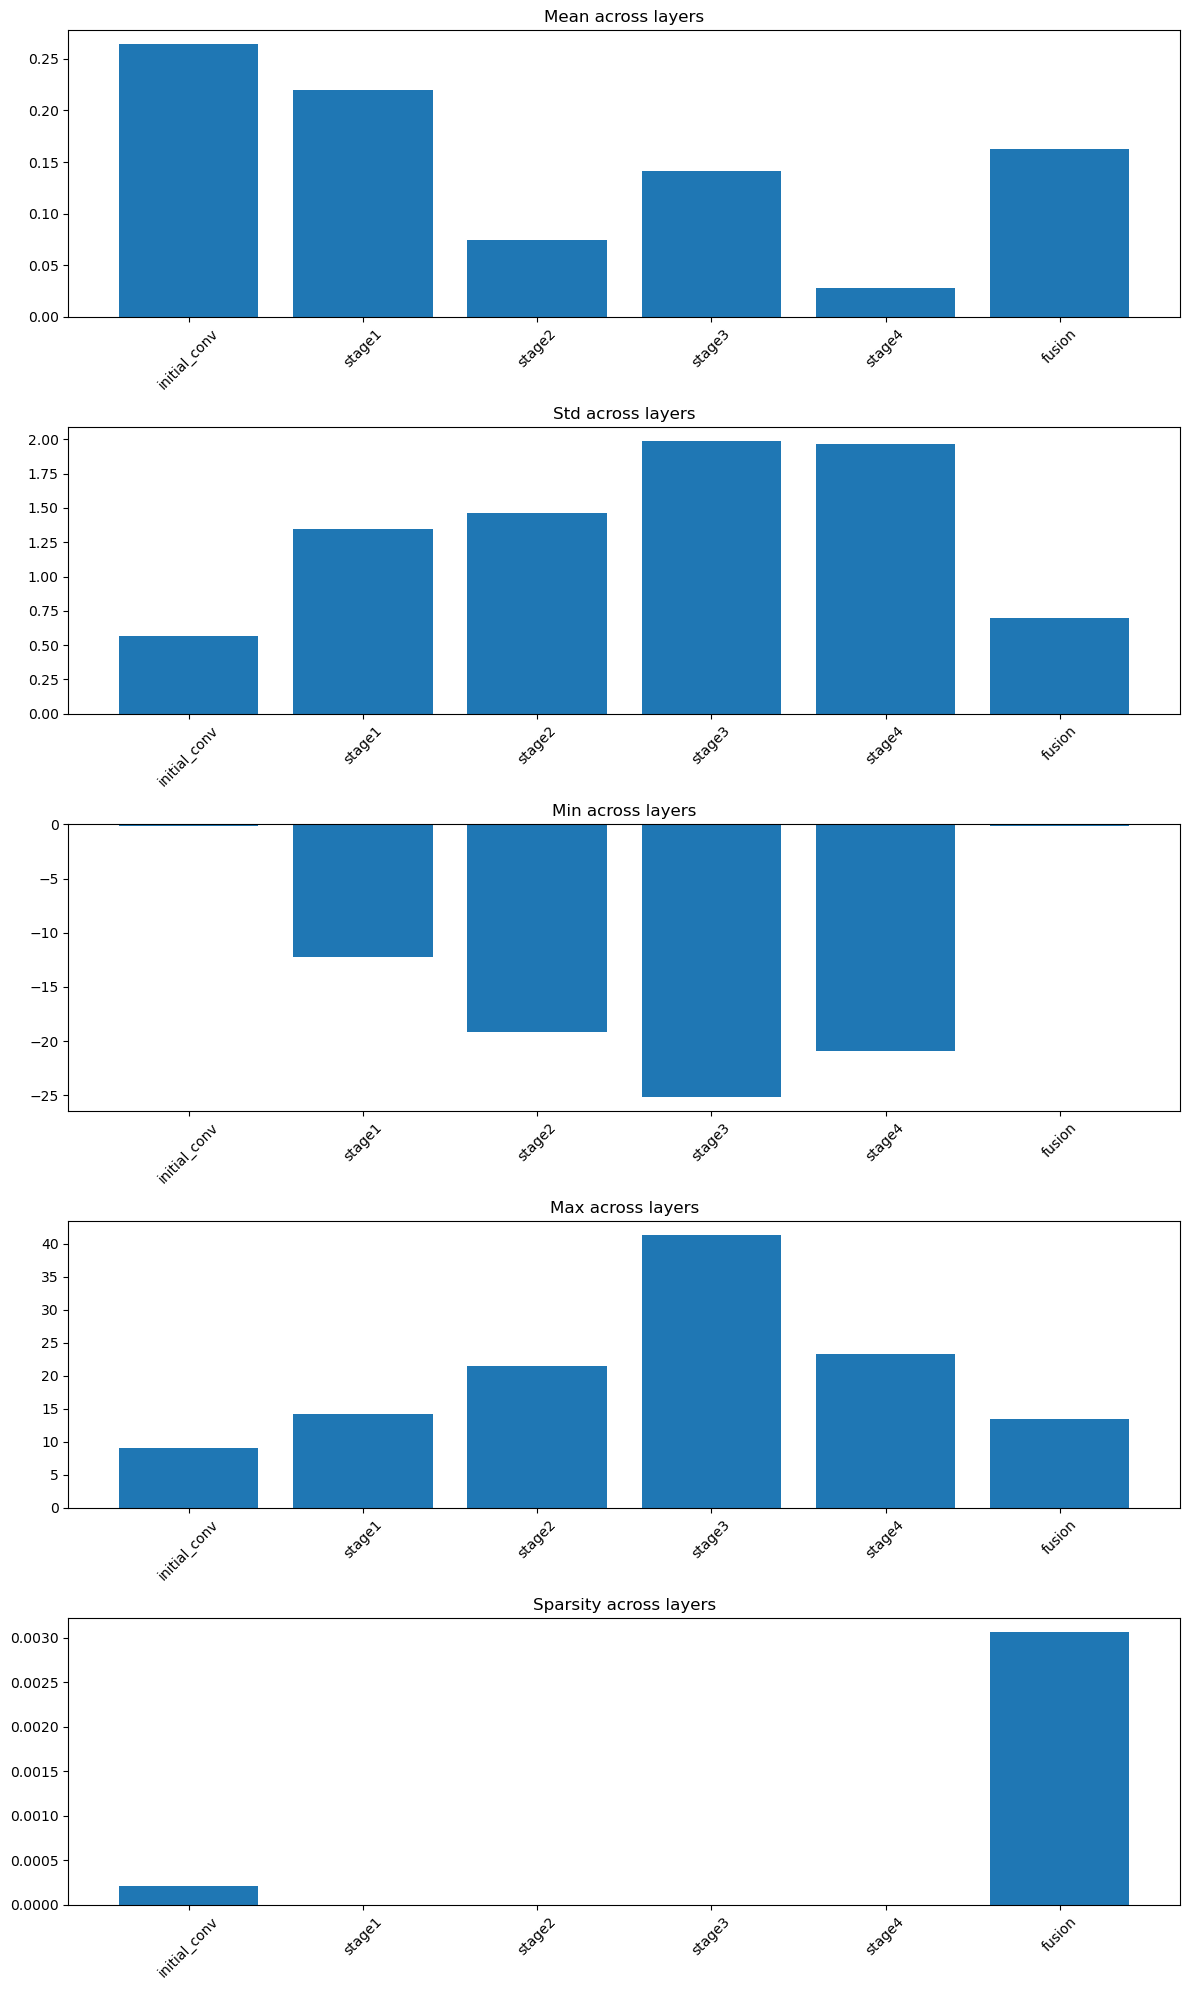


=== Detailed Model Analysis ===

Input Image Shape: torch.Size([1, 1, 512, 512])

INITIAL_CONV LAYER:
Output Shape: (1, 16, 256, 256)
Spatial Reduction: 2.0x
Number of Channels: 16

Statistics:
  Mean Activation: 0.2645
  Std Deviation: 0.5655
  Min/Max Values: -0.1700 / 9.0898
  Sparsity (zero activations): 0.0%

STAGE1 LAYER:
Output Shape: (1, 32, 128, 128)
Spatial Reduction: 4.0x
Number of Channels: 32

Statistics:
  Mean Activation: 0.2202
  Std Deviation: 1.3457
  Min/Max Values: -12.2608 / 14.2426
  Sparsity (zero activations): 0.0%

STAGE2 LAYER:
Output Shape: (1, 64, 64, 64)
Spatial Reduction: 8.0x
Number of Channels: 64

Statistics:
  Mean Activation: 0.0740
  Std Deviation: 1.4631
  Min/Max Values: -19.1850 / 21.5371
  Sparsity (zero activations): 0.0%

STAGE3 LAYER:
Output Shape: (1, 128, 32, 32)
Spatial Reduction: 16.0x
Number of Channels: 128

Statistics:
  Mean Activation: 0.1412
  Std Deviation: 1.9885
  Min/Max Values: -25.1571 / 41.3344
  Sparsity (zero activations): 

In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
import math
import seaborn as sns
from scipy import stats

class EnhancedModelVisualizer:
    def __init__(self, model: nn.Module):
        self.model = model
        self.activation_maps = {}
        self.attention_maps = {}
        self.layer_stats = {}
        self.hooks = []
        self._register_hooks()
    
    def _activation_hook(self, name: str):
        def hook(module, input, output):
            self.activation_maps[name] = output.detach().cpu()
            # Calculate statistical measures
            with torch.no_grad():
                stats = {
                    'mean': float(output.mean()),
                    'std': float(output.std()),
                    'min': float(output.min()),
                    'max': float(output.max()),
                    'sparsity': float((output == 0).float().mean()),
                    'shape': tuple(output.shape)
                }
                self.layer_stats[name] = stats
        return hook

    def _attention_hook(self, name: str):
        def hook(module, input, output):
            if isinstance(module, SEBlock):
                # Store attention weights
                self.attention_maps[name] = output.detach().cpu()
        return hook
    
    def _register_hooks(self):
        # Main component hooks
        components = [
            ('initial_conv', self.model.initial_conv),
            ('stage1', self.model.stage1),
            ('stage2', self.model.stage2),
            ('stage3', self.model.stage3),
            ('stage4', self.model.stage4),
            ('fusion', self.model.fusion_conv)
        ]
        
        for name, component in components:
            self.hooks.append(component.register_forward_hook(
                self._activation_hook(name)))
        
        # SE Block hooks
        for name, module in self.model.named_modules():
            if isinstance(module, SEBlock):
                self.hooks.append(module.register_forward_hook(
                    self._attention_hook(name)))
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def _plot_feature_maps_grid(self, feature_maps: torch.Tensor, 
                              title: str, max_channels: int = 16):
        """Plot multiple feature maps in a grid"""
        # Select a subset of channels
        n_channels = min(feature_maps.shape[0], max_channels)
        feature_maps = feature_maps[:n_channels]
        
        # Calculate grid dimensions
        grid_size = math.ceil(math.sqrt(n_channels))
        fig, axes = plt.subplots(grid_size, grid_size, 
                               figsize=(15, 15))
        fig.suptitle(f'{title}\nShape: {feature_maps.shape}', y=0.95)
        
        # Plot each feature map with different visualization styles
        for idx, feature_map in enumerate(feature_maps):
            if idx >= grid_size * grid_size:
                break
                
            row, col = idx // grid_size, idx % grid_size
            ax = axes[row, col] if grid_size > 1 else axes
            
            # Alternate between different visualization styles
            if idx % 3 == 0:
                # Standard heatmap
                im = ax.imshow(feature_map, cmap='viridis')
            elif idx % 3 == 1:
                # Contour plot
                X, Y = np.meshgrid(np.arange(feature_map.shape[1]),
                                 np.arange(feature_map.shape[0]))
                im = ax.contourf(X, Y, feature_map, levels=20, cmap='magma')
            else:
                # Edge detection style
                im = ax.imshow(feature_map, cmap='RdGy')
            
            ax.axis('off')
            ax.set_title(f'Channel {idx}')
        
        # Remove empty subplots
        for idx in range(n_channels, grid_size * grid_size):
            row, col = idx // grid_size, idx % grid_size
            axes[row, col].remove() if grid_size > 1 else None
        
        plt.tight_layout()
        return fig

    def _plot_attention_maps(self, save_path: str = None):
        """Visualize attention maps from SE blocks"""
        if not self.attention_maps:
            return
        
        n_maps = len(self.attention_maps)
        fig, axes = plt.subplots(1, n_maps, figsize=(5 * n_maps, 4))
        if n_maps == 1:
            axes = [axes]
        
        for idx, (name, attention) in enumerate(self.attention_maps.items()):
            attention = attention.squeeze()
            sns.heatmap(attention.numpy().reshape(-1, 1),
                       cmap='YlOrRd',
                       ax=axes[idx],
                       cbar_kws={'label': 'Attention Weight'})
            axes[idx].set_title(f'SE Block: {name}')
            axes[idx].set_xlabel('Channels')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path.replace('.png', '_attention.png'))
        plt.show()

    def _plot_layer_statistics(self):
        """Plot detailed statistics for each layer"""
        stats_names = ['mean', 'std', 'min', 'max', 'sparsity']
        n_layers = len(self.layer_stats)
        
        fig, axes = plt.subplots(len(stats_names), 1, 
                                figsize=(12, 4 * len(stats_names)))
        
        for idx, stat_name in enumerate(stats_names):
            values = [stats[stat_name] 
                     for stats in self.layer_stats.values()]
            axes[idx].bar(self.layer_stats.keys(), values)
            axes[idx].set_title(f'{stat_name.capitalize()} across layers')
            axes[idx].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

    def visualize_all(self, input_image: torch.Tensor, 
                     save_path: str = None):
        """
        Comprehensive visualization of model's internal representations
        
        Args:
            input_image: Input tensor of shape (1, C, H, W)
            save_path: Optional path to save visualizations
        """
        self.model.eval()
        with torch.no_grad():
            _ = self.model(input_image)
        
        # 1. Feature Maps Visualization
        stages = ['Input Image', 'Initial Conv', 'Stage 1', 'Stage 2',
                 'Stage 3', 'Stage 4', 'Final Fusion']
        
        # Plot input image
        plt.figure(figsize=(10, 10))
        plt.imshow(input_image[0].squeeze(), cmap='gray')
        plt.title(f'Input Image\nShape: {input_image.shape}')
        plt.axis('off')
        if save_path:
            plt.savefig(save_path.replace('.png', '_input.png'))
        plt.show()
        
        # Plot feature maps for each stage
        feature_maps = [
            self.activation_maps['initial_conv'][0],
            self.activation_maps['stage1'][0],
            self.activation_maps['stage2'][0],
            self.activation_maps['stage3'][0],
            self.activation_maps['stage4'][0],
            self.activation_maps['fusion'][0]
        ]
        
        for feature_map, title in zip(feature_maps, stages[1:]):
            fig = self._plot_feature_maps_grid(feature_map, title)
            if save_path:
                fig.savefig(save_path.replace('.png', 
                                            f'_{title.lower().replace(" ", "_")}.png'))
            plt.show()
        
        # 2. Attention Maps Visualization
        self._plot_attention_maps(save_path)
        
        # 3. Layer Statistics Visualization
        self._plot_layer_statistics()
        
        # 4. Print detailed layer information
        self.print_detailed_summary(input_image)

    def print_detailed_summary(self, input_image: torch.Tensor):
        """Print comprehensive summary of transformations and statistics"""
        print("\n=== Detailed Model Analysis ===")
        print(f"\nInput Image Shape: {input_image.shape}")
        
        for name, stats in self.layer_stats.items():
            print(f"\n{name.upper()} LAYER:")
            print(f"Output Shape: {stats['shape']}")
            print(f"Spatial Reduction: {input_image.shape[-1] / stats['shape'][-1]:.1f}x")
            print(f"Number of Channels: {stats['shape'][1]}")
            print("\nStatistics:")
            print(f"  Mean Activation: {stats['mean']:.4f}")
            print(f"  Std Deviation: {stats['std']:.4f}")
            print(f"  Min/Max Values: {stats['min']:.4f} / {stats['max']:.4f}")
            print(f"  Sparsity (zero activations): {stats['sparsity']*100:.1f}%")
            
            if name in self.attention_maps:
                attention = self.attention_maps[name]
                print("\nAttention Statistics:")
                print(f"  Mean Attention Weight: {attention.mean():.4f}")
                print(f"  Max Attention Channel: {attention.argmax().item()}")

def visualize_model_transformations(model_path: str, image_path: str):
    """
    Visualize transformations for a single image through the model
    
    Args:
        model_path: Path to the saved model
        image_path: Path to the input image
    """
    # Load model
    model = LightEfficientMedicalNet(num_classes=5, in_channels=1)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load and preprocess image
    from PIL import Image
    import torchvision.transforms as transforms
    
    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path)
    input_tensor = preprocess(image).unsqueeze(0)
    
    # Create visualizer and generate visualizations
    visualizer = EnhancedModelVisualizer(model)
    
    # Generate comprehensive visualizations
    visualizer.visualize_all(
        input_tensor,
        save_path='model_analysis.png'
    )
    
    # Clean up
    visualizer.remove_hooks()

# Example usage:
visualize_model_transformations('./models/best_model.pth', 'DATASETS/kneeKL224/auto_test/0/9003175_1.png')